# Imports

In [5]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp

from minot.ClusterTools import map_tools
import pitszi

# Data and parameters

In [2]:
outdir = '/Users/adam/Desktop/NIKA_cluster_sample'
reso = 4*u.arcsec
FoV = 4*u.arcmin

In [3]:
# Cluster parameters
cls_name = ['RXJ1347', 'MACSJ1424', 'MACSJ0717', 'PSZ1G046', 'PSZ1G045', 'CLJ1227']
cls_redshift = [0.452, 0.545, 0.546, 0.569, 0.611, 0.888]
cls_M500 = [11.0, 4.9, 11.5, 6.4, 7.0, 5.7]
cls_coord = SkyCoord(['13:47:30.593 -11:45:10.05',  # ACCEPT
                      '14:23:47.759 +24:04:40.45',  # ACCEPT
                      '07:17:31.654 +37:45:18.52',  # ACCEPT
                      '17:17:05.800 +24:04:25.00',  # NIKA proposal
                      '15:18:20.800 +29:27:37.00',  # NIKA proposal
                      '12:26:58.373 +33:32:47.36'], # ACCEPT
                     frame='icrs', unit=(u.hourangle, u.deg))

# Instrument parameters
beam_FWHM    = 18*u.arcsec
FoV_diameter = 2*u.arcmin
TF = []
for ic in cls_name:
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/TransferFunction150GHz_'+ic+'.fits')
    data_TF = hdul[1].data
    TF_i = data_TF['TF'][0]
    TF_i[np.isnan(TF_i)] = 1
    TF.append({'k':data_TF['WAVE_NUMBER_ARCSEC'][0]*u.arcsec**-1/2**0.5, 'TF':TF_i})

# Constants and usefull values
sigma2fwhm = 2 * np.sqrt(2*np.log(2))
y2jy = [-15e3, -11.6e3, -11.6e3, -11.6e3, -11.6e3, -11.6e3]

# Analysis parameters
mask_theta = 1.5*u.arcmin

(0.0, 1.1)

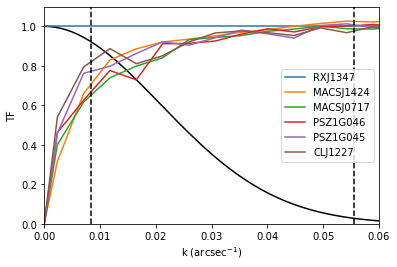

In [4]:
plt.plot(np.linspace(0, 1,1000), pitszi.utils_pk.beam_wf_pk(np.linspace(0, 1,1000), beam_FWHM.to_value('arcsec')), c='k')
for i in range(len(TF)): plt.plot(TF[i]['k'], TF[i]['TF'], label=cls_name[i])
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.legend()
plt.axvline(1/beam_FWHM.to_value('arcsec'), c='k', ls='--')
plt.axvline(1/FoV_diameter.to_value('arcsec'), c='k', ls='--')
plt.xlim(0,0.06)
plt.ylim(0,1.1)

In [5]:
#===== Extract the data
cls_img = []
cls_ps = []
cls_head = []
cls_noise = []
cls_rms = []

for ic in range(len(cls_name)):  
    print('----- Getting '+cls_name[ic]+' data')
    # Data image
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/MAP150GHz_'+cls_name[ic]+'.fits')
    new_header = map_tools.define_std_header(hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2'],
                                             FoV.to_value('deg'), FoV.to_value('deg'), reso.to_value('deg'))
    img_ini  = hdul[0].data /y2jy[ic]
    img_ini, _ = reproject_interp((img_ini, hdul[0].header), new_header)
    cls_head.append(new_header)

    # Point source model
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/PointSourceModel150GHz_'+cls_name[ic]+'.fits')
    img_ps = hdul[0].data /y2jy[ic]
    img_ps, _ = reproject_interp((img_ps, hdul[0].header), new_header)
    cls_img.append(img_ini - img_ps)
    cls_ps.append(img_ps)
    
    # Noise
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/NoiseMC150GHz_'+cls_name[ic]+'.fits')
    noise = hdul[1].data/y2jy[ic]    
    noise =  np.swapaxes(np.swapaxes(noise, 2,0), 1,2)
    noise_rep = np.zeros((len(noise[:,0,0]), img_ini.shape[0], img_ini.shape[1]))
    for imc in range(len(noise[:,0,0])):
        repro, _ = reproject_interp((noise[imc,:,:], hdul[0].header), new_header)
        noise_rep[imc,:,:] = repro
    cls_noise.append(noise_rep)
    cls_rms.append(np.std(noise_rep, axis=0))

----- Getting RXJ1347 data
----- Getting MACSJ1424 data
----- Getting MACSJ0717 data
----- Getting PSZ1G046 data
----- Getting PSZ1G045 data
----- Getting CLJ1227 data


# Define the model, data and inference

In [6]:
cls_model = []
cls_data = []
cls_infer = []
for ic in range(len(cls_img)):
    #========== Create directories
    if not os.path.exists(outdir+'/'+cls_name[ic]): 
        os.makedirs(outdir+'/'+cls_name[ic]) 
    
    #========== cluster model
    cluster = pitszi.Model(name=cls_name[ic], RA=cls_coord[ic].ra, Dec=cls_coord[ic].dec, 
                           redshift=cls_redshift[ic], M500=cls_M500[ic]*1e14*u.Msun, 
                           silent=True, output_dir=outdir+'/'+cls_name[ic])
    cluster.set_pressure_profile_universal_param('A10UPP')
    cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                          'Norm': 0.5, 
                                          'slope': -11/3.0,
                                          'Linj': 1*u.Mpc,
                                          'Ldis': 1*u.kpc}

    cluster.map_header = cls_head[ic]
    cluster.los_reso  = 100*u.kpc
    cluster.los_size  = 2*u.Mpc
    cluster.R_truncation = cluster.R500*5

    print('')
    print('----- Scale: '+cls_name[ic]+' -----')
    print('Pixel size in kpc: ', cluster.get_map_reso(physical=True))
    print('FoV in Mpc: ', cluster.get_map_fov(physical=True))
    
    cls_model.append(cluster)
    
    #========== cluster data
    data = pitszi.Data(cls_img[ic], cls_head[ic], silent=True, output_dir=outdir+'/'+cls_name[ic])
    data.psf_fwhm              = beam_FWHM
    data.transfer_function     = TF[ic]

    #----- Define the noise properties
    data.noise_mc = cls_noise[ic]
    data.set_noise_model_from_mc()
    data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000)
    data.noise_rms = data.get_noise_rms_from_model(Nmc=1000)

    #----- Define the mask
    rmss = gaussian_filter(data.noise_rms, sigma=20/3600/sigma2fwhm/cls_head[ic]['CDELT2'])
    mask = rmss * 0 + 1
    data.mask[rmss > 2*np.amin(rmss)] = 0
    
    #----- Append data
    cls_data.append(data)
    
    #========== Inference
    infer = pitszi.Inference(data, cluster, silent=True)
    infer.output_dir = outdir+'/'+cls_name[ic]
    
    infer.kbin_min   = 1/FoV
    infer.kbin_max   = 1/(10*u.arcsec)
    infer.kbin_Nbin  = 8
    infer.kbin_scale = 'log'
    
    infer.method_use_covmat  = False
    infer.method_parallel    = False
    infer.method_data_deconv = False
        
    cls_infer.append(infer)

#========== Sampling information
cluster.give_sampling_information()
print('kcounts:', infer.get_kbin_counts())


----- Scale: RXJ1347 -----
Pixel size in kpc:  23.79851323905828 kpc
FoV in Mpc:  [1451.70930758 1451.70930758] kpc

----- Scale: MACSJ1424 -----
Pixel size in kpc:  26.293137256264163 kpc
FoV in Mpc:  [1603.88137263 1603.88137263] kpc

----- Scale: MACSJ0717 -----
Pixel size in kpc:  26.317146668368224 kpc
FoV in Mpc:  [1605.34594677 1605.34594677] kpc

----- Scale: PSZ1G046 -----
Pixel size in kpc:  26.854200694701174 kpc
FoV in Mpc:  [1638.10624238 1638.10624238] kpc

----- Scale: PSZ1G045 -----
Pixel size in kpc:  27.76337349101625 kpc
FoV in Mpc:  [1693.56578295 1693.56578295] kpc

----- Scale: CLJ1227 -----
Pixel size in kpc:  31.92183472415166 kpc
FoV in Mpc:  [1947.23191817 1947.23191817] kpc
===== Information relative to the grid sampling =====
   Grid size : 61 , 61 , 21
   Pixel size :      31.9     kpc ;     4.0      arcsec
   Fov size :  [   1947.2   ,   1947.2   ] kpc ; [   4.067    ,   4.067    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyC

# Fit the smooth model to the data

In [7]:
for inf_i in cls_infer:
    print('---------- '+inf_i.model.name)
    RA = inf_i.model.coord.ra
    Dec = inf_i.model.coord.dec
    fitpar_prof = {
        #'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
        #'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
        #'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
        #'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
        #'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
        'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10UPP'},
        'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
        'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
        'RA': {'guess':[RA.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-0.5, RA.to_value('arcmin')+0.5]},
        'Dec': {'guess':[Dec.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-0.5, Dec.to_value('arcmin')+0.5]},
        'ZL':{'guess':[0,1e-5],'unit':None},
                  }
    
    plist, popt, pcov = inf_i.run_curvefit_profile(fitpar_prof, 
                                                   show_fit_result=True, 
                                                   set_bestfit=True)

---------- RXJ1347
param 0 (M500): 
   median   = 25.24122950712146 -1.403331058586307 +1.5820197185968965
   best-fit = 23.931311499008466 -0.09341305047331261 +2.891937726709891
   M500 = 25.24122950712146_{-1.403331058586307}^{1.5820197185968965}
param 1 (RA): 
   median   = 12412.871016259396 -0.045072397606418235 +0.04362808143196162
   best-fit = 12412.87343240438 -0.04748854259014479 +0.041211936448235065
   RA = 12412.871016259396_{-0.045072397606418235}^{0.04362808143196162}
param 2 (Dec): 
   median   = -705.3760573886832 -0.043092171115176825 +0.04253516148469316
   best-fit = -705.358758230681 -0.06039132911735123 +0.025236003482518754
   Dec = -705.3760573886832_{-0.043092171115176825}^{0.04253516148469316}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.9445653985350705 -0.06075945217893752 +0.03924067566372702
   best-fit = 0.9944756516107661 -0.11066970525463316 +-0.010669577411968612
   min_to_maj_axis_ratio = 0.9445653985350705_{-0.06075945217893752}^{0.039240675663

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- MACSJ1424
param 0 (M500): 
   median   = 14.927880929154306 -1.5268748496752682 +1.684487675195463
   best-fit = 13.565593119134881 -0.16458703965584398 +3.046775485214887
   M500 = 14.927880929154306_{-1.5268748496752682}^{1.684487675195463}
param 1 (RA): 
   median   = 12956.8465584047 -0.06808579817879945 +0.06843947649758775
   best-fit = 12956.884353669606 -0.10588106308387069 +0.030644211592516513
   RA = 12956.8465584047_{-0.06808579817879945}^{0.06843947649758775}
param 2 (Dec): 
   median   = 1444.6895159776648 -0.06284839160753108 +0.06334296896147862
   best-fit = 1444.6684698335173 -0.04180224746005479 +0.08438911310895492
   Dec = 1444.6895159776648_{-0.06284839160753108}^{0.06334296896147862}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.8963891498118293 -0.11067792610918537 +0.0715105368808936
   best-fit = 0.9653982069557134 -0.17968698325306953 +0.0025014797370094266
   min_to_maj_axis_ratio = 0.8963891498118293_{-0.11067792610918537}^{0.0715105368808936

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- MACSJ0717
param 0 (M500): 
   median   = 21.035228357728005 -0.7441901939162356 +0.7887857179652897
   best-fit = 21.031868375095794 -0.7408302112840239 +0.7921457005975014
   M500 = 21.035228357728005_{-0.7441901939162356}^{0.7887857179652897}
param 1 (RA): 
   median   = 6563.324392786508 -0.021778923629426572 +0.02184624652545608
   best-fit = 6563.331008382181 -0.028394519302310073 +0.01523065085257258
   RA = 6563.324392786508_{-0.021778923629426572}^{0.02184624652545608}
param 2 (Dec): 
   median   = 2265.274730881904 -0.013827405531628756 +0.013772472814707726
   best-fit = 2265.2993849133086 -0.038481436936308455 +-0.010881558589971974
   Dec = 2265.274730881904_{-0.013827405531628756}^{0.013772472814707726}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.7454218941785253 -0.027728111232470987 +0.02697576166430693
   best-fit = 0.7281295612921317 -0.01043577834607734 +0.044268094550700576
   min_to_maj_axis_ratio = 0.7454218941785253_{-0.027728111232470987}^{0.0269

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- PSZ1G046
param 0 (M500): 
   median   = 14.957546502012374 -2.6934338350165756 +2.6281848171808733
   best-fit = 15.008079682024892 -2.743967015029094 +2.577651637168355
   M500 = 14.957546502012374_{-2.6934338350165756}^{2.6281848171808733}
param 1 (RA): 
   median   = 15556.839314886092 -0.07669165691731905 +0.06613714540799265
   best-fit = 15556.763312984831 -0.0006897556559124496 +0.14213904666939925
   RA = 15556.839314886092_{-0.07669165691731905}^{0.06613714540799265}
param 2 (Dec): 
   median   = 1444.3037730970286 -0.06311387042296701 +0.06514078569693993
   best-fit = 1444.315729038461 -0.07506981185542827 +0.05318484426447867
   Dec = 1444.3037730970286_{-0.06311387042296701}^{0.06514078569693993}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.5630858676249468 -0.10422809940499556 +0.10431021140284102
   best-fit = 0.5657525711654424 -0.10689480294549114 +0.10164350786234544
   min_to_maj_axis_ratio = 0.5630858676249468_{-0.10422809940499556}^{0.10431021140284

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- PSZ1G045
param 0 (M500): 
   median   = 16.450363248315128 -1.4020317222710172 +1.3908889048717548
   best-fit = 16.347595798339118 -1.299264272295007 +1.493656354847765
   M500 = 16.450363248315128_{-1.4020317222710172}^{1.3908889048717548}
param 1 (RA): 
   median   = 13774.846540501236 -0.04197661450962187 +0.04189817425140063
   best-fit = 13774.7897940122 --0.014769874525882187 +0.09864466328690469
   RA = 13774.846540501236_{-0.04197661450962187}^{0.04189817425140063}
param 2 (Dec): 
   median   = 1767.3900809976376 -0.031237091012826568 +0.03297318651243586
   best-fit = 1767.3854689710688 -0.02662506444403334 +0.037585213081229085
   Dec = 1767.3900809976376_{-0.031237091012826568}^{0.03297318651243586}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.608632121787006 -0.05481379453402124 +0.05371337522416486
   best-fit = 0.6075428809074748 -0.053724553654490026 +0.05480261610369608
   min_to_maj_axis_ratio = 0.608632121787006_{-0.05481379453402124}^{0.0537133752241

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- CLJ1227
param 0 (M500): 
   median   = 11.720224095479232 -0.819524071793083 +0.8432916531794454
   best-fit = 11.725727081703225 -0.825027058017076 +0.8377886669554524
   M500 = 11.720224095479232_{-0.819524071793083}^{0.8432916531794454}
param 1 (RA): 
   median   = 11204.28988318943 -0.024356742262170883 +0.02463606839774002
   best-fit = 11204.281883667005 -0.01635721983620897 +0.03263559082370193
   RA = 11204.28988318943_{-0.024356742262170883}^{0.02463606839774002}
param 2 (Dec): 
   median   = 2012.702835984206 -0.02381241063494599 +0.024348895963157702
   best-fit = 2012.6893590020047 -0.01033542843356372 +0.03782587816453997
   Dec = 2012.702835984206_{-0.02381241063494599}^{0.024348895963157702}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.7974787230055768 -0.05384467121717795 +0.05609430578284724
   best-fit = 0.8153985947309255 -0.07176454294252665 +0.03817443405749854
   min_to_maj_axis_ratio = 0.7974787230055768_{-0.05384467121717795}^{0.05609430578284724

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


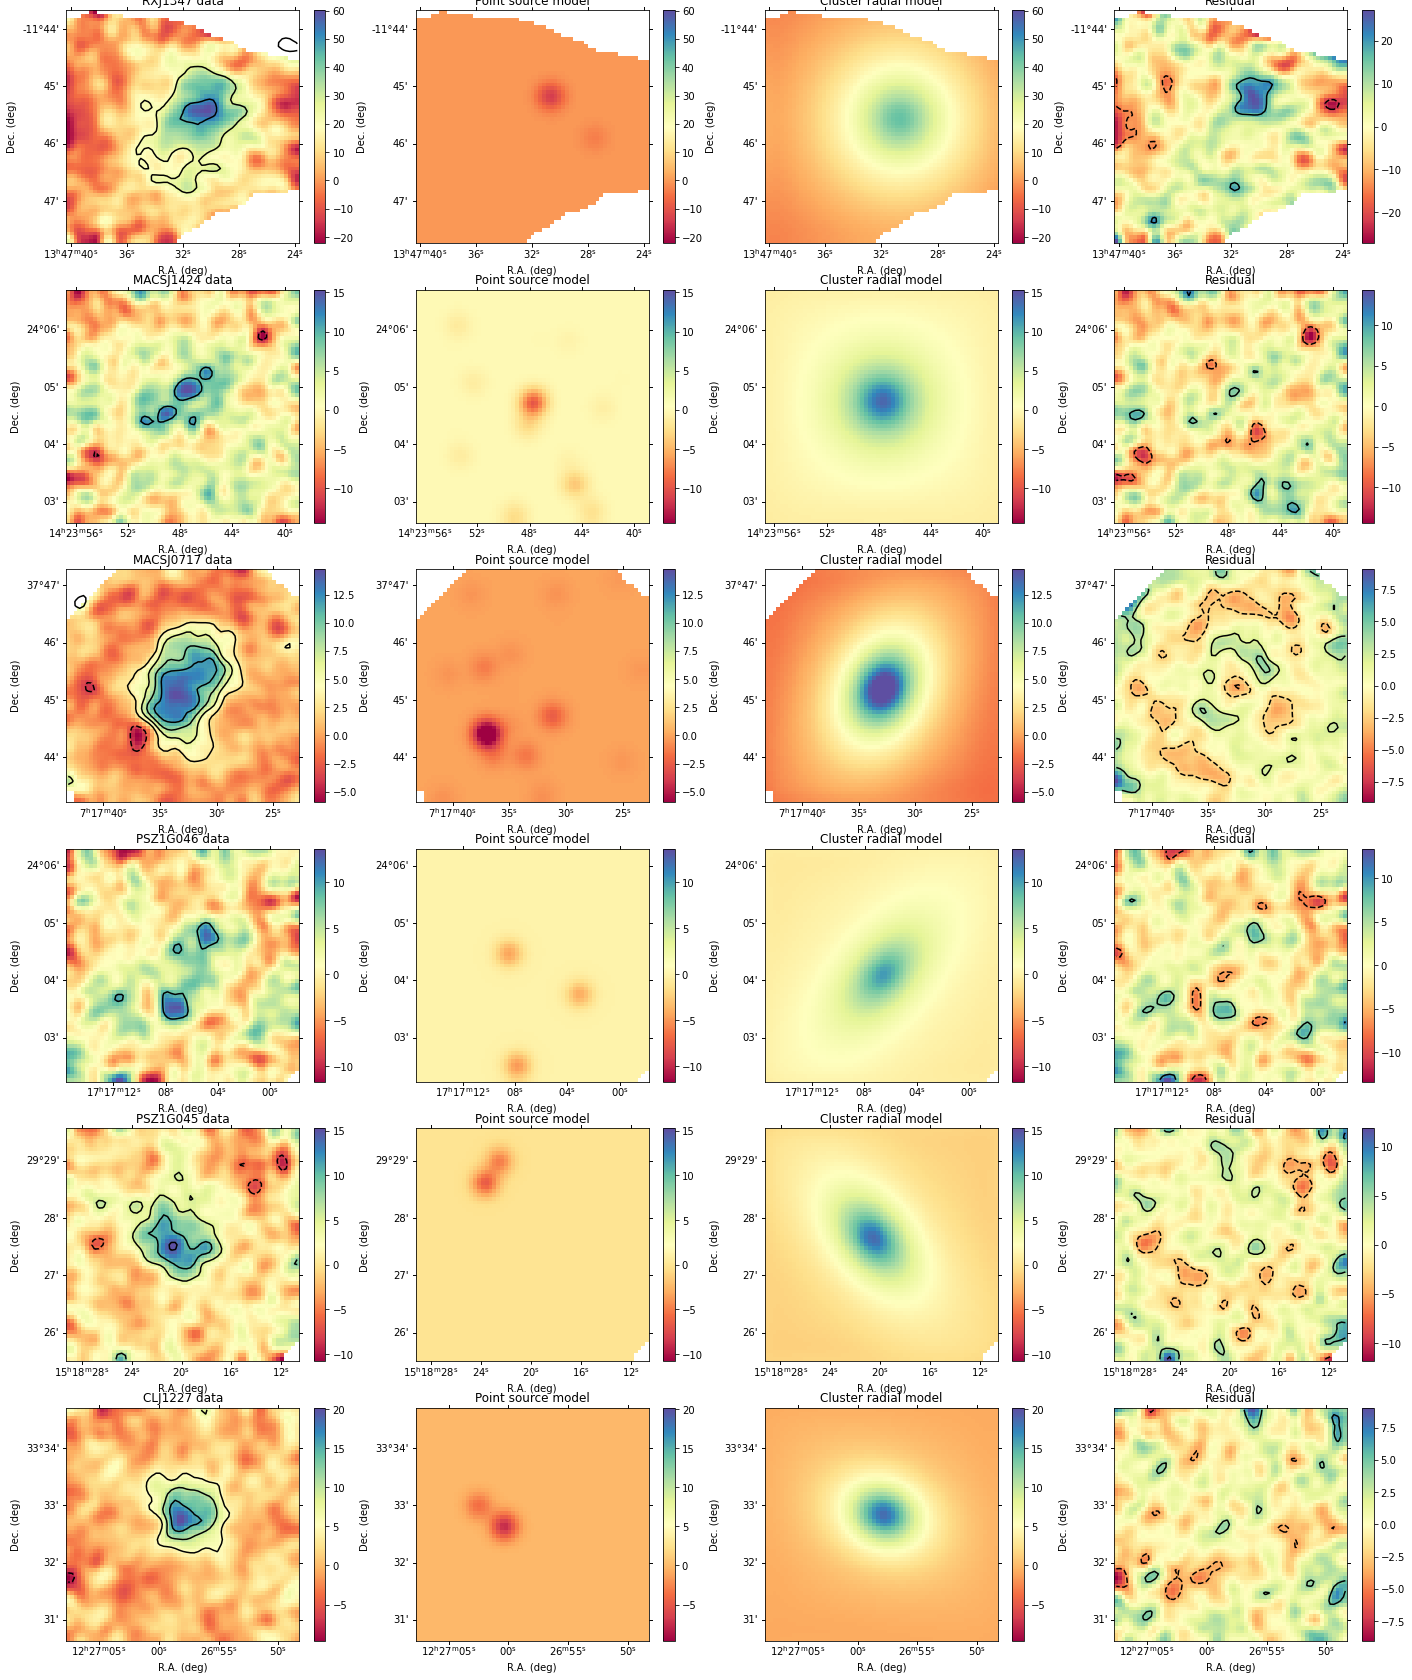

In [8]:
smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(24, 5*len(cls_img)))
for ic in range(len(cls_img)):
    model_sph = cls_infer[ic].get_radial_model()
    
    rms = cls_data[ic].get_noise_rms_from_model(Nmc=1000, smooth_fwhm=smooth_FWHM)
    rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cls_head[ic]['CDELT2'])
    
    rng = [np.nanmin(cls_data[ic].mask*gaussian_filter(cls_img[ic]+cls_ps[ic], sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5),
           np.nanmax(cls_data[ic].mask*gaussian_filter(cls_img[ic]+cls_ps[ic], sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5)]

    msk = cls_data[ic].mask
    msk[cls_data[ic].mask == 0] = np.nan
    
    #----- Image
    ax = plt.subplot(len(cls_img), 4, 4*ic+1, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(cls_img[ic]+cls_ps[ic], 
                                    sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.contour(gaussian_filter(cls_img[ic]+cls_ps[ic], 
                                sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])
                /rms, levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
    plt.title(cls_name[ic]+' data')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Point source model
    ax = plt.subplot(len(cls_img), 4, 4*ic+2, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(cls_ps[ic], 
                                    sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.title('Point source model')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Cluster model
    ax = plt.subplot(len(cls_img), 4, 4*ic+3, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.title('Cluster radial model')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Residual
    rng = np.nanmax(msk*np.abs(gaussian_filter(cls_img[ic]-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5))
    ax = plt.subplot(len(cls_img), 4, 4*ic+4, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(cls_img[ic]-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=-rng, vmax=rng)
    cb = plt.colorbar()
    plt.contour(msk*gaussian_filter(cls_img[ic]-model_sph, 
                                sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])
                /rms, levels=[-8,-6,-4,-2,2,4,6,8], colors='k')
    plt.title('Residual')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')

In [9]:
#========== Setup for Pk and save
for inf_i in cls_infer:
    print(' ')
    print('---------- '+inf_i.model.name)
    
    # Parameters
    inf_i.silent = False
    inf_i.method_use_covmat  = True
    
    # Region of interest mask
    ramap, decmap = map_tools.get_radec_map(inf_i.data.header)
    dist_map = map_tools.greatcircle(ramap, decmap, 
                                     inf_i.model.coord.ra.to_value('deg'), 
                                     inf_i.model.coord.dec.to_value('deg'))
    roi_mask = dist_map * 0 + 1
    roi_mask[dist_map > mask_theta.to_value('deg')] = 0 
    
    # Weight definition
    inf_i.set_method_w8(roi_mask=roi_mask,
                        apply_data_mask=True,
                        apply_radial_model=True, 
                        conv_radial_model_beam=True, 
                        conv_radial_model_TF=False, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=20*u.arcsec)
    
    # Setup and save
    inf_i.pk_setup(Nmc = 100)
    inf_i.save_inference()

---------- RXJ1347
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [   4.   12.   16.   32.  108.  200.  468. 1032.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----
---------- MACSJ1424
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [   4.   12.   16.   32.  108.  200.  468. 1032.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----
---------- MACSJ0717
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [   4.   12.   16.   32.  108.  200.  468. 1032.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup 

# Extract the 3d power spectrum

In [10]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }
for inf_i in cls_infer:
    print('---------- '+inf_i.model.name)
    plist, popt, pcov = inf_i.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

---------- RXJ1347
----- Checking the Pk setup -----
      The setup was done. We can proceed, but still make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 1.7138552997143237 -1.0345630215529282 +0.8961567117225937
   best-fit = 2.867949282276479 -2.1886570041150835 +-0.2579372708395615
   Norm = 1.7138552997143237_{-1.0345630215529282}^{0.8961567117225937}
param 1 (Linj): 
   median   = 222.64279750654939 -42.131606191853194 +43.05191679973095
   best-fit = 183.56422614969085 -3.053034834994662 +82.13048815658948
   Linj = 222.64279750654939_{-42.131606191853194}^{43.05191679973095}
param 2 (Anoise): 
   median   = 0.733908885292831 -0.05629602635389408 +0.056066672813417595
   best-fit = 0.6914531839800075 -0.013840325041070578 +0.0985223741262411
   Anoise = 0.733908885292831_{-0.05629602635389408}^{0.056066672813417595}
---------- MACSJ1424
----- Checking the Pk setup -----
      The setup was done. We can proceed, but still make sure tha

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


ValueError: It looks like the parameter(s) in column(s) 0, 1 have no dynamic range. Please provide a `range` argument.